This notebook contains the second Coffee-Grading Model, which will know classify beans into 4 categories, imitating the original taks even closer.

In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, models

Model 1. Regular CNN. Similar to the model that works with 2 classes, yet this one has 4.

In [2]:
data_dir = 'data'
print(os.listdir(data_dir))

['defect', 'longberry', 'peaberry', 'premium']


Sub-Model1

In [3]:
data = tf.keras.utils.image_dataset_from_directory('data') # Here, we load the data from the directory

Found 8000 files belonging to 4 classes.


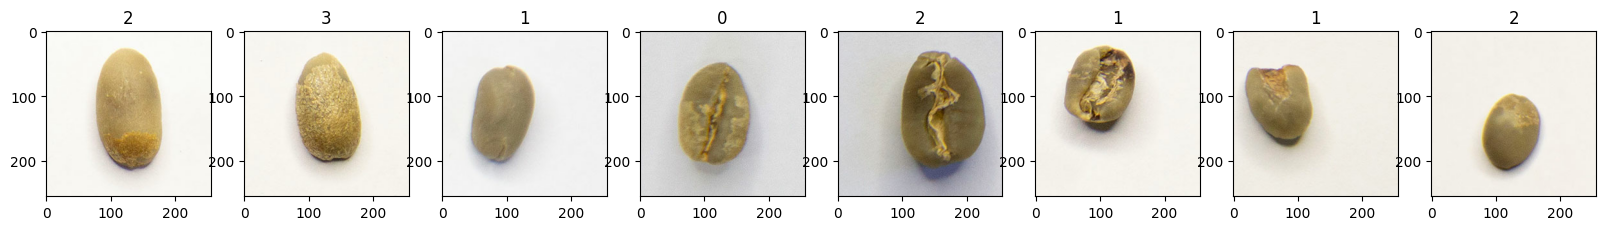

In [4]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=8, figsize=(20,20)) 
for idx, img in enumerate(batch[0][8:16]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [5]:
def normalize(x, y):
    return x / 255, y

data = data.map(normalize)

In [6]:
total_size = len(data)
train_size = math.floor(total_size * 0.7)
val_size = math.floor(total_size * 0.2)
test_size = total_size - train_size - val_size

In [13]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)
len(train)

175

In [8]:
model = Sequential()
model.add(Conv2D(32, (2, 2), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, (2, 2), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (2, 2), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Changing to 4 for four classes and using softmax

In [9]:
# Compile the model with the updated loss function
learning_rate = 0.0005  
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 255, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 126, 64)      8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        8224      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0

In [10]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [11]:
# hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

In [12]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Validation Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

NameError: name 'hist' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Validation Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    yhat = tf.argmax(yhat, axis=1)  # Convert predictions to label indices
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    accuracy.update_state(y, yhat)

In [ ]:
print(precision.result().numpy(), recall.result().numpy(), accuracy.result().numpy())

In [ ]:
model.save(os.path.join('models','CoffeeModel2.h5'))

Model 2.  Residual Neural Network. Residual neural network will allow us to create a tryly deep neural network with many layers, which will still be susceptible to training, because it is, well, residual.

In [46]:
def residual_block(x, filters, kernel_size=3, stride=1):
    x_og = x
    
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x) 
    # Batch normalization helps prevent Internal Covariate Shift by normalizing the data.
    # After normalization, the normalized activations are scaled and shifted using learnable parameters γ and 𝛽
    # Also, Batch Normalization reduces this dependency, making the training process less sensitive 
    # to the initial starting conditions.
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    
    if stride != 1 or x.shape[-1] != x_og.shape[-1]: # In case the shape of the output of the block is different from the input one
        x_og = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_initializer='he_normal')(x_og)
        x_og = layers.BatchNormalization()(x_og)
    
    x = layers.add([x, x_og]) # Here we add the input to the output of a block. 
    x = layers.ReLU()(x)
    
    return x

In [47]:
def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, padding='same', kernel_initializer='he_normal')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, x)
    
    return model


In [48]:
input_shape = (256, 256, 3)  
num_classes = 4

model = build_resnet(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 128, 128, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_20 (BatchN  (None, 128, 128, 64  256        ['conv2d_23[0][0]']              
 ormalization)                  )                                                           

In [49]:
logdir='logs2'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [50]:
def one_hot_encode(data, label):
    num_classes = 4  # Set this to the number of classes in your dataset
    label = tf.one_hot(label - 1, num_classes)  # Subtract 1 to make labels zero-based for one-hot encoding
    return data, label


In [51]:
one_hot_train = train.map(one_hot_encode)
one_hot_valid = val.map(one_hot_encode)
one_hot_test = test.map(one_hot_encode)

In [52]:
for data, label in one_hot_test.take(1):
    print("Data shape:", data.shape)
    print("Label shape:", label.shape)
    print("Label:", label.numpy())

Data shape: (32, 256, 256, 3)
Label shape: (32, 4)
Label: [[0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


In [ ]:
hist2 = model.fit(one_hot_train, epochs=40, validation_data=one_hot_valid, callbacks=[tensorboard_callback])

Epoch 1/40
175/175 [==============================] - 43s 247ms/step - loss: 0.8376 - accuracy: 0.4059 - val_loss: 2.3613 - val_accuracy: 0.5181
Epoch 2/40
175/175 [==============================] - 44s 250ms/step - loss: 0.8577 - accuracy: 0.4134 - val_loss: 10.7313 - val_accuracy: 0.2600
Epoch 3/40
175/175 [==============================] - 44s 251ms/step - loss: 0.8985 - accuracy: 0.3957 - val_loss: 0.9874 - val_accuracy: 0.5044
Epoch 4/40
175/175 [==============================] - 44s 252ms/step - loss: 0.8919 - accuracy: 0.4229 - val_loss: 2.4977 - val_accuracy: 0.4894
Epoch 5/40
175/175 [==============================] - 44s 253ms/step - loss: 0.8820 - accuracy: 0.4129 - val_loss: 2.0387 - val_accuracy: 0.4956
Epoch 6/40
175/175 [==============================] - 45s 254ms/step - loss: 0.8674 - accuracy: 0.4427 - val_loss: 2.6267 - val_accuracy: 0.0000e+00
Epoch 7/40
175/175 [==============================] - 45s 255ms/step - loss: 0.8541 - accuracy: 0.4525 - val_loss: 2.0734 - v

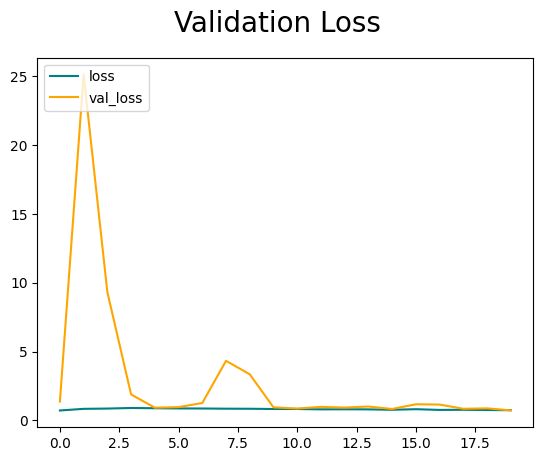

In [45]:
fig = plt.figure()
plt.plot(hist2.history['loss'], color='teal', label='loss')
plt.plot(hist2.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Validation Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

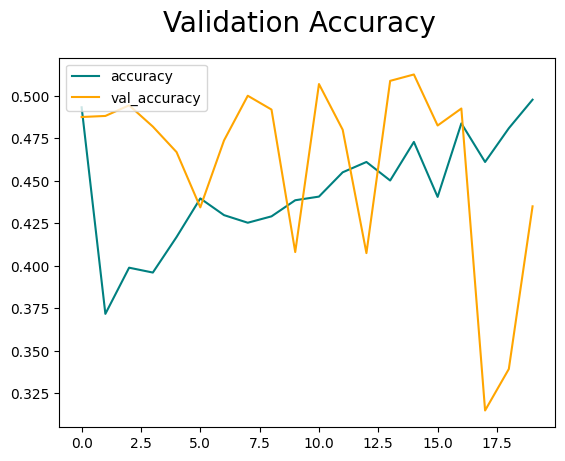

In [40]:
fig = plt.figure()
plt.plot(hist2.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist2.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Validation Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
model.save(os.path.join('models','CoffeeModel3.h5'))